# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." For this year's week 2 machine learning challenge, BWSI has revived a past PhysioNet challenge based on sleep classification.

This year's challenge focuses on the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [1]:
### Import libraries ###

# from google.colab import files
import matplotlib.pyplot as plt
import matplotlib

#set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from scipy.signal import find_peaks
import tensorflow as tf

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class descriptions:**

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/sleepStagesTable.svg?raw=true">

***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography) (EEG)

E1-M2 - left eye activity (electrooculography) (EOG)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [2]:
# Clone repo and move into data directory (only run this once)
# !git clone https://github.com/BeaverWorksMedlytics2020/Data_Public
# os.chdir('./Data_Public/ChallengeProjects/Week2/')

data_directory = "~/Documents/Github/Medlytics/Data_Public/ChallengeProjects/Week2/"

## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals. 
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data. 
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the training data.

We encourage you to print each of these variables to see what they look like.

In [3]:
### Run once to import data ###

def get_file_locs():
    '''
    find all files in 'training' and 'test' directories and put their names 
    under 'training' and 'test' keys in the file_dict dictionary
    '''

    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)
    
    return file_dict

def get_sample_data(data_type, id_number):
    '''
    get signal data, label, and filename associated with given data type and index num

    parameters:

     data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

     id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

     sample_data -- dataframe with 1 row and 2 columns-- column "Signal" contains a series object 
                    and column "Label" contains numeric label for that sample
    '''
    file = './' + data_type + '/' + str(id_number) + '.xz'

    #sample_data is a dataframe with 1 row and 2 columns--
    #"Signal" (contains a series object) and "Label" (contains numeric label)
    sample_data = pd.read_pickle('./' + file)

    return sample_data, file.split('/')[2]

file_dict = get_file_locs()
print(f"{len(file_dict['training'])} training samples found, {len(file_dict['test'])} test samples found")

data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample_data, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample_data['Signal']), dtype=np.float).reshape(12000, 7)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=np.float)
  ID_train.append(ID)
  if(i%500==0):
    print('Loading training sample ' + str(i))
  
data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample_data, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample_data['Signal']), dtype=np.float).reshape(12000, 7)
  ID_test.append(ID)
  if(i%500==0):
    print('Loading test sample ' + str(i))

#keep original copy of data_train, labels_train, ID_train, data_test, and ID_test
# (for plotting or reference in case variables are shuffled later on)
data_train_orig = data_train.copy()
labels_train_orig = labels_train.copy()
ID_train_orig = ID_train.copy()
data_test_orig = data_test.copy()
ID_test_orig = ID_test.copy()

4000 training samples found, 1000 test samples found
Loading training sample 0
Loading training sample 500
Loading training sample 1000
Loading training sample 1500
Loading training sample 2000
Loading training sample 2500
Loading training sample 3000
Loading training sample 3500
Loading test sample 0
Loading test sample 500


## Data Visualization

Run the cell below to visualize the raw data for a single 60s sample for all 7 signals. We strongly urge you to visualize a few different samples to get a feel for how the data looks and how much each signal can vary in amplitude and frequency from sample to sample. You can change which sample is being visualized by changing the arguments to the graph_signals call.

Training 1093 (NREM1)


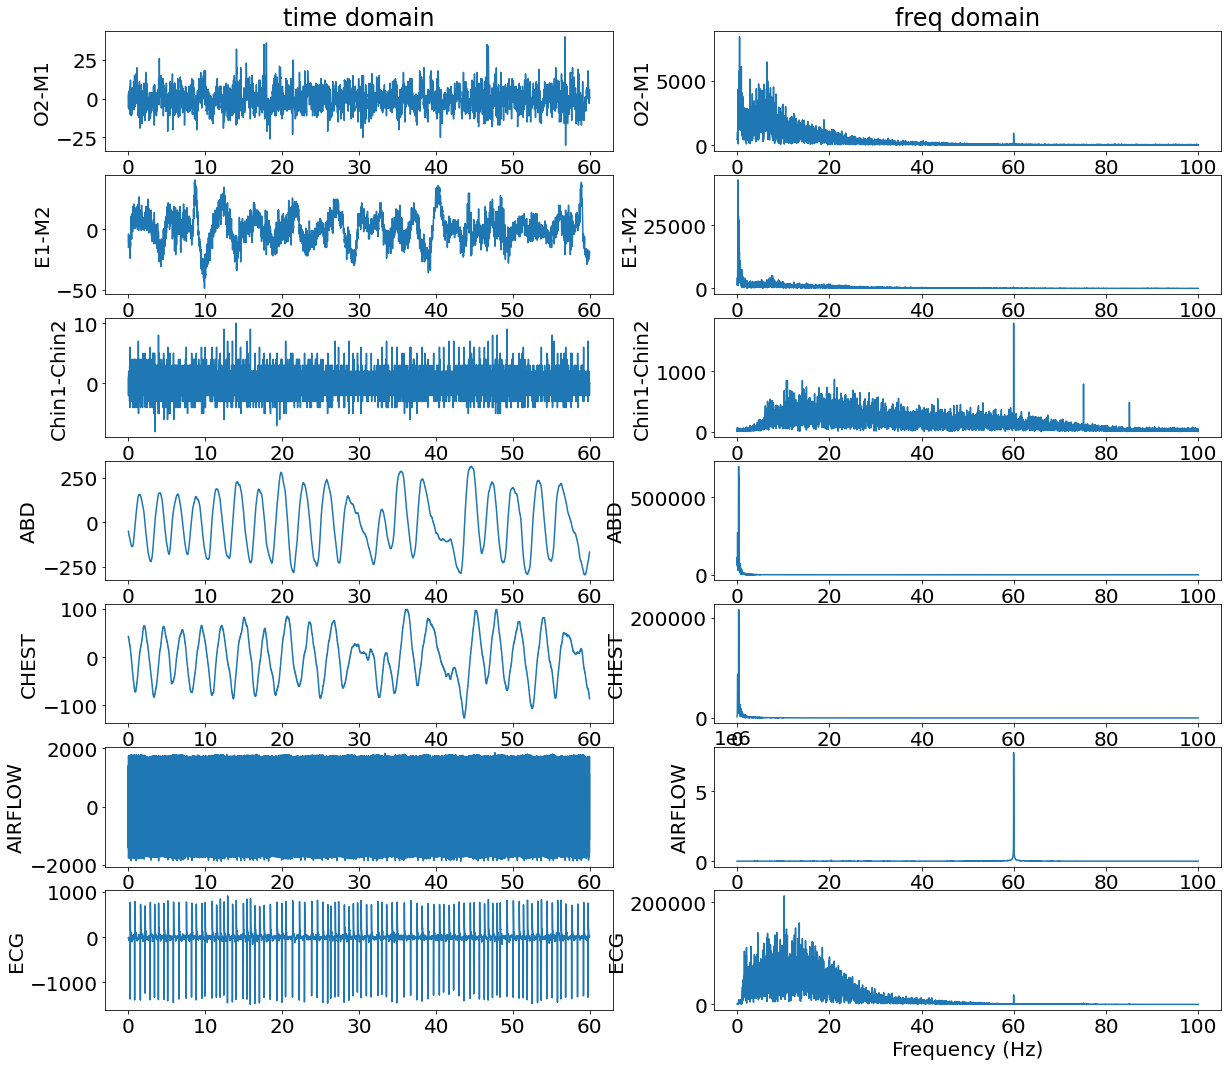

In [5]:
### Define some useful functions to retrieve and plot data from individual samples ###

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

def graph_signals(data_type = 'training', id_number = None):
    '''
    Create a graph of multiple signals, with rows representing signal class, and
    columns representing signal domain (i.e. time or frequency) 
    
    inputs:
    
      parameters:

      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    '''

    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'

    if id_number is None:
      if data_type == 'training':
        id_number = random.randint(0,3999)
      else:
        id_number = random.randint(0,999)

    #set time_signal_y based on 'test' or 'training' input
    if data_type == 'training':
        time_signal_y = data_train_orig[id_number,:,:]
    else:
        time_signal_y = data_test_orig[id_number,:,:]

    #Get signal values in time domain from either data_train_orig, or data_test_orig
    time_signal_x = np.arange(0, 60, step = 1/200) #this time axis doesn't change

    #Use time-domain signals to get frequency domain signals
    num_datapoints = time_signal_x.shape[0]
    freq_signal_x = np.arange(num_datapoints//2 + 1)/60
    freq_signal_y = np.ndarray(shape = (num_datapoints//2 + 1, 7))
    freq_signal_y = np.abs(np.fft.rfft(time_signal_y, axis = 0))
    

    plt.figure(figsize = (20, 18))
    title_list = ['time domain', 'freq domain']
    for signal_index in range(7): #7 classes of signal (O2-M1, E2-M2, etc.)
        for signal_domain_index in range(2): #2 types of signal (time and freq domain)
            plt.subplot(7, 2, 2*signal_index + signal_domain_index + 1)
            if signal_index==0:
                plt.title(title_list[signal_domain_index])
            if signal_domain_index == 0: #plot time domain signal
                plt.plot(time_signal_x, time_signal_y[:,signal_index])
            if signal_domain_index == 1: #plot freq domain signal
                plt.plot(freq_signal_x, freq_signal_y[:,signal_index])
            plt.ylabel(sig_dict[signal_index])
        plt.xlabel(sig_type_dict[signal_domain_index])
    plt.show()

# We can now use the above functions to retrieve data for a single sample 
# (in the test or training set) and then plot it

#change these 2 lines to plot different samples (note that test set only has 1000 samples)
data_type = 'training'
id_number = random.randint(0,3999)

#print signal ID and the sample label (if known)
if data_type == 'training': 
    print(data_type.title(), str(id_number), '(' + stage_dict[id_number//800] + ')')
else: 
    print(data_type.title(), str(id_number), '(Unknown)')

#plot data from this sample
graph_signals(data_type = data_type, id_number = id_number)

## Example Classifier

Below is an example of a mediocre classifier for this dataset. It is a simple neural network that uses the spectral flatness of all signal classes its input features--that is, it has 7 input features.

While the example classifier makes use of a neural network, we encourage you to utilize any ML algorithm that you feel would be appropriate.

In [173]:
def spectral_flatness(signal, fft, zero_thresh = 1e-10): 
    N = len(signal) 
    magnitude = abs(fft[:N//2])* 2 / N
    if(zero_thresh is not None):
        magnitude[magnitude < zero_thresh] = zero_thresh
    if(any(magnitude<zero_thresh)):
        raise ValueError("This shouldn't happen")
    sf = mstats.gmean(magnitude) / np.mean(magnitude) 
    return sf

def spectral_centroid(signal, fft, f_s=200):
    fft = np.abs(fft)
    N = len(signal)
    T = 1/f_s # Sample rate [s], time between 2 consecutive samples
    # x_signal = np.arange(N//2)*T # 200Hz signal [should be 6000 datapoints, 3 seconds]
    x_fft = np.arange(N//2)/(N*T)
    
    rem = int(np.round(60/(N*T)))
    fft[rem-2:rem+3] = 0; # remove region around 60 hz
    
    return (x_fft*fft[:N//2]).sum()/x_fft.sum()

def range_signal(signal, fft):
    return signal.max() - signal.min()

def stdev_signal(signal, fft):
    return np.std(signal)

def range_t10_freq(signal, fft, f_s=200):
    fft = np.abs(fft)
    N=len(fft)
    
    
    rem = int(np.round(60*N/f_s))
    fft[rem-2:rem+3] = 0; # remove region around 60 hz
    
    peaks = find_peaks(fft[:len(fft)//2], height=np.quantile(fft, 0.9))
    if(len(peaks[0]) == 0):
        return 0
    return peaks[0][-1] - peaks[0][0]

def spectral_flux(signal, ft, f_s=200):
    """The even cooler feature extractor I wrote"""
    #Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)
    
    rem = int(np.round(60*len(ft)/f_s))
    ft[rem-2:rem+3] = 0; # remove region around 60 hz

    #Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples//2]
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)

    magnitudeNorm = normalize(magnitude[:,np.newaxis], axis=0)[:,0]

    #Compute spectral flux
    specFlux = 0.0
    
    #for t in range(1,len(magnitudeNorm)):
    #    specFlux += np.square(magnitudeNorm[t] - magnitudeNorm[t - 1])
    specFlux = np.sum(np.square(np.diff(magnitudeNorm)))
    
    return specFlux

def spectral_flux2(signal, fft, f_s=200):
    N=len(fft)
    
    rem = int(np.round(60*N/f_s))
    fft[rem-2:rem+3] = 0; # remove region around 60 hz
    
    return np.sum(np.square(np.diff(np.diff(np.abs(fft[:N//2])*2/N))))

def stdev_ft(signal, fft, f_s=200):
    rem = int(np.round(60*len(fft)/f_s))
    fft[rem-2:rem+3] = 0

    return np.std(np.abs(fft[:len(fft)//2]))

def spectral_bandwidth(signal, ft, p=2, f_s=200): #DO NOT USE
    """The cool feature extractor I wrote"""
    assert( False )
    #Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    #Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples//2]
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)

    #Compute spectral bandwidth
    specBand = np.power(np.sum(magnitude * np.power(freqs - spectral_centroid(signal, ft, f_s), p)), float(float(1) / float(p)))
    return specBand



In [501]:
### Define functions that calculate the features of a single sample ###

import scipy.stats.mstats as mstats

#I'm going to use spectral_flatness of the fft as a feature that could be used



def get_features_for_single_sample(data_type = 'training', id_number = None):
    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'
    if id_number is None: id_number=random.randint(0,999)
    if data_type == 'training': time_signal_y = data_train_orig[id_number,:,:]
    else: time_signal_y = data_test_orig[id_number,:,:]
  
    #---Populate feature vector ---
    
    fft_arr = np.fft.rfft(time_signal_y, axis = 0)
    
    feature_list=[
        (0, spectral_flatness), # O2-M1   EEG  - 3/5
        (0, spectral_centroid), # O2-M1   EEG  - 4/5
        (0, stdev_signal),      # O2-M1   EEG  - 3/5
        (0, stdev_ft),          # O2-M1   EEG  - 2.5/5
        (0, spectral_flux2),    # O2-M1   EEG  - 3.5/5
        (1, spectral_flatness), # E1-M2   EOG  - ?/5
        (1, spectral_centroid), # E1-M2   EOG  - 3/5
        (1, range_signal),      # E1-M2   EOG  - 4/5
        (1, stdev_signal),      # E1-M2   EOG  - 3/5
        (1, stdev_ft),          # E1-M2   EOG  - 2/5
        (1, spectral_flux2),    # E1-M2   EOG  - 3/5
        (2, spectral_flatness), # chin         - ?/5
        (2, spectral_centroid), # chin         - 4/5
        (2, range_signal),      # chin         - 2/5
        (2, stdev_signal),      # chin         - 2/5
        (2, stdev_ft),          # chin         - 3/5
        (2, spectral_flux2),    # chin         - 3/5
        (3, spectral_flux),     # abdomen      - 2/5
    ]
    N = len(feature_list)
    feature_vector = np.zeros((N,1))
    
    for i in range(N):
        x = feature_list[i]
        feature_vector[i] = x[1](time_signal_y[:,x[0]], fft_arr[:,x[0]])
    
    return feature_vector
    
def get_features(data_type, num_samples):
    '''
    Retrieve features from num_samples samples in either test or training set, 
    return features for each sample and index of each sample
    
    inputs:
    
      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      num_samples -- For how many samples should features be calculated?
                  (should not exceed total samples in a given data_type)
  
    returns:

      features -- n x p array of feature values for all samples where rows 
                  correspond to samples and columns correspond to feature number

      order -- 1d array where index i contains the index of row i of the feature vector
               (only needed if shuffling takes place later)
    '''

    features, order = np.array([]), np.array([])
    cnt=0
    for i in np.arange(num_samples):
        single_sample_features = get_features_for_single_sample(data_type = data_type, id_number = i)
        features = np.hstack((features, single_sample_features)) if features.size else single_sample_features
        order = np.append(order, i).astype(np.float32)
        
        if(i>=cnt):
            print("passed {}".format(i))
            cnt+=400

    #ensure features are of type float32    
    features = features.astype(np.float32)

    return np.transpose(features), order


In [502]:
### Run every time you modify your feature extraction ###

train_size = 4000

print('calculating features for training data...')
train_data, train_order = get_features('training', train_size)


print('calculating features for test data...')
test_data, test_order = get_features('test', 1000)

print('Done!')

#print(train_data[:10])
all_data = np.vstack((train_data, test_data))

all_data = all_data.transpose()
for i in range(len(all_data)):
    hi,lo = np.quantile(all_data[i],.98), np.quantile(all_data[i],.02)
    all_data[i][all_data[i]>hi] = hi
    all_data[i][all_data[i]<lo] = lo
all_data = normalize(all_data).transpose()

train_data = all_data[:train_size]
test_data = all_data[train_size:]

# print(len(train_data), len(test_data))

print("Fully Completed")

calculating features for training data...
passed 0
passed 400
passed 800
passed 1200
passed 1600
passed 2000
passed 2400
passed 2800
passed 3200
passed 3600
calculating features for test data...
passed 0
passed 400
passed 800
Done!
Fully Completed


## Visualize Entire Dataset's Features

In [503]:
### Create label array for all training samples using categorical datatype ###

train_labels = np.ndarray(shape = (1, train_size))

#set labels to integers first
for i in range(train_size):
    train_labels[0][i] = int(train_order[i])//800 # This is a way to label each entry (since classes are in order)
    
#convert labels to onehot, ensure type is float32
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5)
train_labels = train_labels.astype(np.float32)


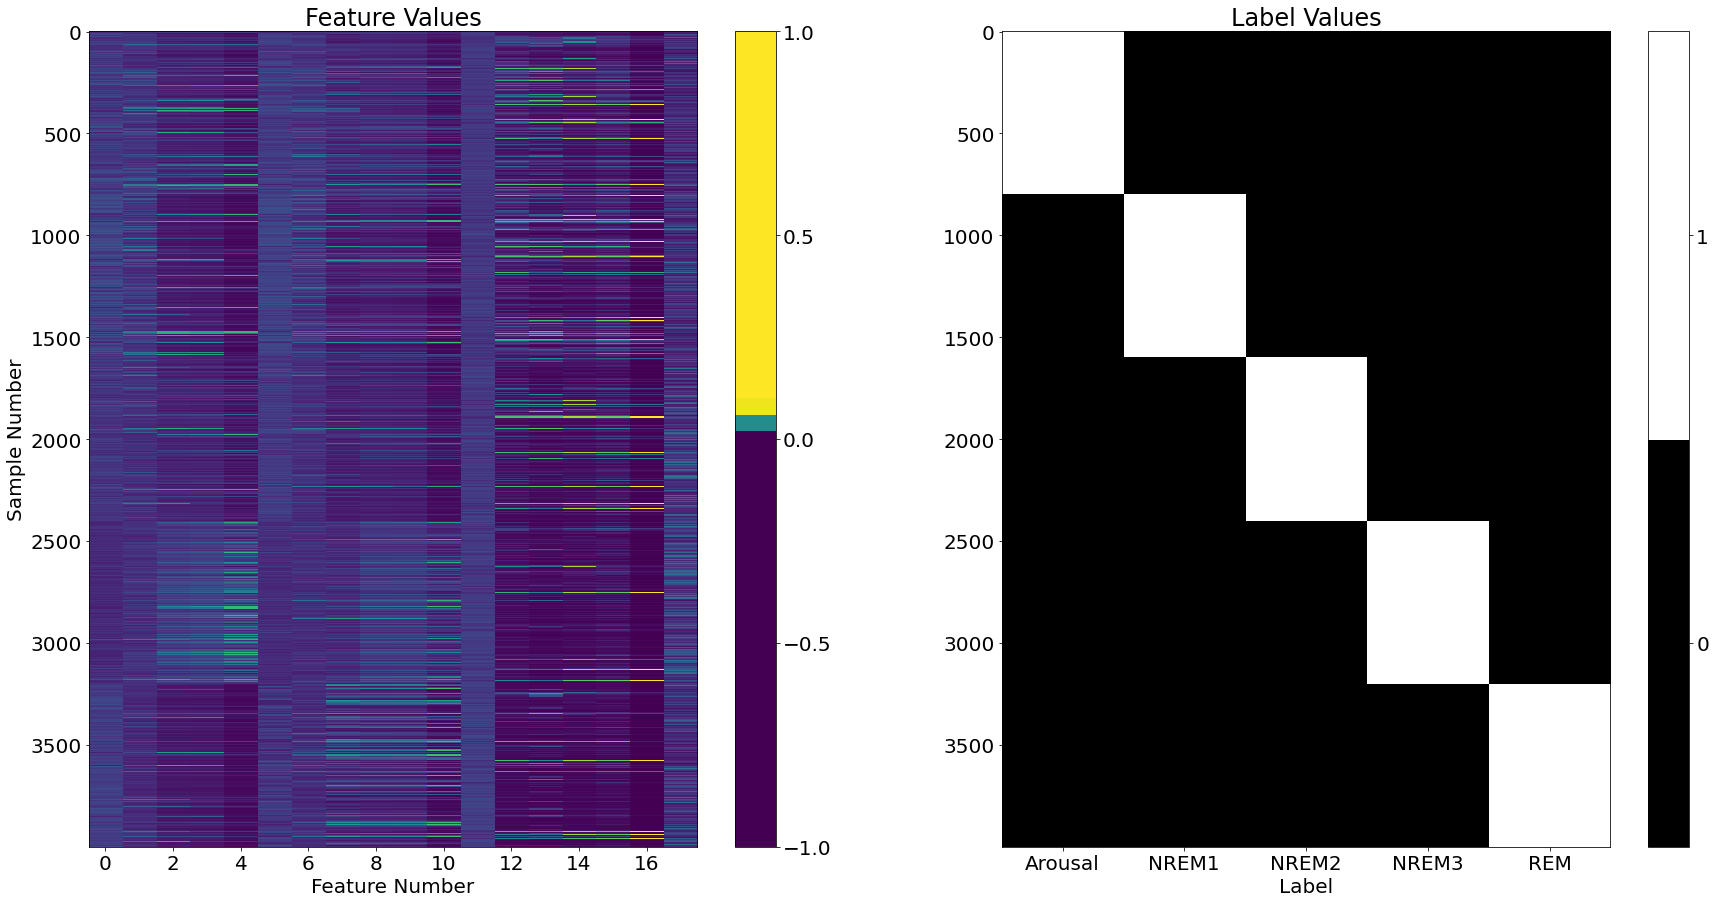

In [504]:
### Run whenever you want to check or view your data and labels ###
# print(f"train_data.shape = {train_data.shape} \n train_labels.shape = {train_labels.shape}\n\n")
# print(f"train data:\n {train_data}\n\ntrain labels:\n {train_labels}")
#plot feature values and label values to show data clearly
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize= (30,15))

#Note: if your features are not scaled to the range 0->1 you might want to change vmin and vmax
featureImg = ax1.imshow(train_data[:,:], aspect = 'auto', interpolation = 'None')# vmin = 0, vmax = 1.0)
ax1.set_title('Feature Values')
ax1.set_ylabel('Sample Number')
ax1.set_xlabel('Feature Number')
fig.colorbar(featureImg, ax = ax1, boundaries = np.linspace(-1.0, 1.0, 50), ticks = [-1,-0.5,0,0.5,1])
# fig.colorbar(featureImg, ax = ax1)

from matplotlib.colors import ListedColormap
bw_cmap = ListedColormap(np.array([[0,0,0,1],[1,1,1,1]])) # make a colormap manually
labelImg = ax2.imshow(train_labels, aspect = 'auto', cmap = bw_cmap,interpolation = 'None', vmin = 0, vmax = 1.0)
ax2.set_title('Label Values')
ax2.set_xlabel('Label')
ax2.set_xticks(range(len(stage_dict)))
ax2.set_xticklabels([stage_dict[i] for i in range(len(stage_dict))])
fig.colorbar(labelImg, ax = ax2, boundaries = np.linspace(-0.5, 1.5,3), ticks = [0, 1])

In [505]:
#### Run every time you modify your feature extraction ###
#
# This cell splits up the labeled data into 3 subsets (training data, validation
# data, and test data)
#
# This 3-way split is very common in training a supervised learning model. The purpose of
# each partition is as follows:
#
# 1) Training data is used to adjust model weights (so-called model parameters)
# 2) Validation data is used to gauge how well model generalizes (allowing user 
#    to compare between different trained models and/or non-trained model 
#    parameters (hyperparameters))
# 3) Test data is used to provide an indicator of real-world performance (it 
#    should not be used when deciding between models because this would result 
#    in overfitting!)

train_data_shuffled, train_labels_shuffled = shuffle(train_data, train_labels, random_state = 25)

""" val_size (int) must be from 0-4000 """
val_size = 1000
mocktest_size = 500

# val_size = train_size*2//10
# mocktest_size = train_size//10

val_data = train_data_shuffled[:val_size]
mocktest_data = train_data_shuffled[val_size:val_size + mocktest_size]
partial_train_data = train_data_shuffled[val_size + mocktest_size:]

val_labels = train_labels_shuffled[:val_size]
mocktest_labels = train_labels_shuffled[val_size:val_size + mocktest_size]
partial_train_labels = train_labels_shuffled[val_size + mocktest_size:]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.batch(40) #set batch size


In [506]:
### Run every time you change set of parameters ###

model = tf.keras.Sequential()

""" Modify to your heart's and algorithm's content ^_^ """

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dropout(rate=0.6))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
#model.add(tf.keras.layers.Dropout(rate=0.6))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

#model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
# we should end with a softmax to ensure outputs behave like probabilities
#(i.e. sum to 1)
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax)) 

#opt = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
#Another potential optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 64)                1216      
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_316 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_317 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_318 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_319 (Dense)            (None, 5)                 645       
Total params: 30,853
Trainable params: 30,853
Non-trainable params: 0
_________________________________________________

In [512]:
### Run whenever you want to train and validate your model ###

"""
EPOCHS (int) the number of times the optimization algorithm passes
through the full dataset (calculating errors and derivatives) to update weights
(One pass through the data is called an "epoch")
"""

EPOCHS = 200

for epoch in range(EPOCHS):
    for signals, labels in training_set:
        tr_loss, tr_accuracy = model.train_on_batch(signals, labels)
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)
    print(('Epoch #%d\t TL: %.3f\tTA: %.3f\t'
         'VL: %.3f\tVA: %.3f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

32/32 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.5940
Epoch #1	 TL: 0.946	TA: 0.700	VL: 0.989	VA: 0.594
32/32 [==============================] - 0s 2ms/step - loss: 0.9682 - accuracy: 0.5990
Epoch #2	 TL: 1.004	TA: 0.650	VL: 0.968	VA: 0.599
32/32 [==============================] - 0s 1ms/step - loss: 0.9811 - accuracy: 0.6040
Epoch #3	 TL: 0.991	TA: 0.700	VL: 0.981	VA: 0.604
32/32 [==============================] - 0s 1ms/step - loss: 0.9638 - accuracy: 0.6110
Epoch #4	 TL: 0.738	TA: 0.750	VL: 0.964	VA: 0.611
32/32 [==============================] - 0s 1ms/step - loss: 0.9585 - accuracy: 0.6060
Epoch #5	 TL: 0.699	TA: 0.800	VL: 0.959	VA: 0.606
32/32 [==============================] - 0s 1ms/step - loss: 0.9644 - accuracy: 0.6000
Epoch #6	 TL: 0.781	TA: 0.750	VL: 0.964	VA: 0.600
32/32 [==============================] - 0s 1ms/step - loss: 0.9631 - accuracy: 0.6000
Epoch #7	 TL: 0.850	TA: 0.650	VL: 0.963	VA: 0.600
32/32 [==============================] - 

32/32 [==============================] - 0s 3ms/step - loss: 0.9718 - accuracy: 0.6060
Epoch #60	 TL: 0.899	TA: 0.650	VL: 0.972	VA: 0.606
32/32 [==============================] - 0s 1ms/step - loss: 0.9660 - accuracy: 0.6030
Epoch #61	 TL: 0.830	TA: 0.700	VL: 0.966	VA: 0.603
32/32 [==============================] - 0s 1ms/step - loss: 0.9759 - accuracy: 0.5990
Epoch #62	 TL: 0.814	TA: 0.650	VL: 0.976	VA: 0.599
32/32 [==============================] - 0s 2ms/step - loss: 0.9607 - accuracy: 0.6040
Epoch #63	 TL: 0.695	TA: 0.750	VL: 0.961	VA: 0.604
32/32 [==============================] - 0s 2ms/step - loss: 0.9540 - accuracy: 0.6180
Epoch #64	 TL: 0.793	TA: 0.750	VL: 0.954	VA: 0.618
32/32 [==============================] - 0s 1ms/step - loss: 0.9578 - accuracy: 0.6050
Epoch #65	 TL: 0.716	TA: 0.750	VL: 0.958	VA: 0.605
32/32 [==============================] - 0s 2ms/step - loss: 0.9469 - accuracy: 0.6140
Epoch #66	 TL: 0.904	TA: 0.700	VL: 0.947	VA: 0.614
32/32 [===========================

32/32 [==============================] - 0s 1ms/step - loss: 0.9639 - accuracy: 0.6080
Epoch #119	 TL: 0.801	TA: 0.700	VL: 0.964	VA: 0.608
32/32 [==============================] - 0s 1ms/step - loss: 0.9767 - accuracy: 0.6020
Epoch #120	 TL: 0.888	TA: 0.650	VL: 0.977	VA: 0.602
32/32 [==============================] - 0s 1ms/step - loss: 0.9653 - accuracy: 0.6090
Epoch #121	 TL: 0.711	TA: 0.750	VL: 0.965	VA: 0.609
32/32 [==============================] - 0s 1ms/step - loss: 0.9483 - accuracy: 0.6110
Epoch #122	 TL: 0.809	TA: 0.700	VL: 0.948	VA: 0.611
32/32 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.6020
Epoch #123	 TL: 0.771	TA: 0.750	VL: 0.987	VA: 0.602
32/32 [==============================] - 0s 2ms/step - loss: 0.9523 - accuracy: 0.6120
Epoch #124	 TL: 0.732	TA: 0.750	VL: 0.952	VA: 0.612
32/32 [==============================] - 0s 2ms/step - loss: 0.9593 - accuracy: 0.6080
Epoch #125	 TL: 0.732	TA: 0.750	VL: 0.959	VA: 0.608
32/32 [====================

32/32 [==============================] - 0s 1ms/step - loss: 0.9643 - accuracy: 0.6060
Epoch #178	 TL: 0.721	TA: 0.750	VL: 0.964	VA: 0.606
32/32 [==============================] - 0s 2ms/step - loss: 0.9504 - accuracy: 0.6170
Epoch #179	 TL: 0.987	TA: 0.650	VL: 0.950	VA: 0.617
32/32 [==============================] - 0s 2ms/step - loss: 0.9652 - accuracy: 0.6060
Epoch #180	 TL: 0.779	TA: 0.700	VL: 0.965	VA: 0.606
32/32 [==============================] - 0s 1ms/step - loss: 0.9574 - accuracy: 0.6110
Epoch #181	 TL: 0.738	TA: 0.750	VL: 0.957	VA: 0.611
32/32 [==============================] - 0s 1ms/step - loss: 0.9566 - accuracy: 0.6110
Epoch #182	 TL: 0.825	TA: 0.700	VL: 0.957	VA: 0.611
32/32 [==============================] - 0s 1ms/step - loss: 0.9561 - accuracy: 0.6030
Epoch #183	 TL: 0.764	TA: 0.750	VL: 0.956	VA: 0.603
32/32 [==============================] - 0s 1ms/step - loss: 0.9516 - accuracy: 0.6130
Epoch #184	 TL: 0.741	TA: 0.750	VL: 0.952	VA: 0.613
32/32 [====================

In [445]:
### Run every time you modify your feature extraction ###

#test_size = 1000
#
#print('calculating features for test data...')
#test_data, test_order = get_features('test', test_size)
#
#
## print('calculating features for test data...')
## test_data, test_order = get_features('test', 1000)
#
#print('Done!')
#
## print(test_data[:10])
#test_data = test_data.transpose();
#for i in range(len(test_data)):
#    hi,lo = np.quantile(test_data[i],.95), np.quantile(test_data[i],.05)
#    test_data[i][test_data[i]>hi] = hi
#    test_data[i][test_data[i]<lo] = lo
#test_data = normalize(test_data).transpose()
## print(test_data[:10])
#
#print("Fully Completed")

In [351]:
### Run once after you have finished training your model ###

test_pred = model.predict(test_data)
test_output = np.ndarray(shape = (1000, 6))

# """ Add column with file number """
for i in range(1000):
    test_output[i] = np.append(test_pred[i], test_order[i]) 
test_dataframe = pd.DataFrame(test_output)

""" Sort dataframe according to file number """
sorted_test_dataframe = test_dataframe.sort_values(by=[5])

""" Drop file number column """
processed_test_dataframe = sorted_test_dataframe.drop(sorted_test_dataframe.columns[5], axis=1)

print(test_dataframe.head(), '\n\n', sorted_test_dataframe.head(), '\n\n', processed_test_dataframe.head())

file = 'unladenSwallow.xz'
processed_test_dataframe.to_pickle(file)
test_dataframe = pd.DataFrame(test_output)
# os.listdir('.')
# files.download(file)


          0         1         2         3         4    5
0  0.010413  0.003804  0.057551  0.927563  0.000669  0.0
1  0.510192  0.394250  0.090163  0.004587  0.000808  1.0
2  0.075940  0.249799  0.482490  0.003222  0.188548  2.0
3  0.153118  0.096139  0.325803  0.026069  0.398871  3.0
4  0.634969  0.176418  0.116797  0.060366  0.011450  4.0 

           0         1         2         3         4    5
0  0.010413  0.003804  0.057551  0.927563  0.000669  0.0
1  0.510192  0.394250  0.090163  0.004587  0.000808  1.0
2  0.075940  0.249799  0.482490  0.003222  0.188548  2.0
3  0.153118  0.096139  0.325803  0.026069  0.398871  3.0
4  0.634969  0.176418  0.116797  0.060366  0.011450  4.0 

           0         1         2         3         4
0  0.010413  0.003804  0.057551  0.927563  0.000669
1  0.510192  0.394250  0.090163  0.004587  0.000808
2  0.075940  0.249799  0.482490  0.003222  0.188548
3  0.153118  0.096139  0.325803  0.026069  0.398871
4  0.634969  0.176418  0.116797  0.060366  0.01145

## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below. 

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity. There will be a "winning" group for each of these categories.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/MultiClassRocCurve_exampleClassifier.png?raw=true" width="600" height="500">

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.727
- MCC: 0.163
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [513]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

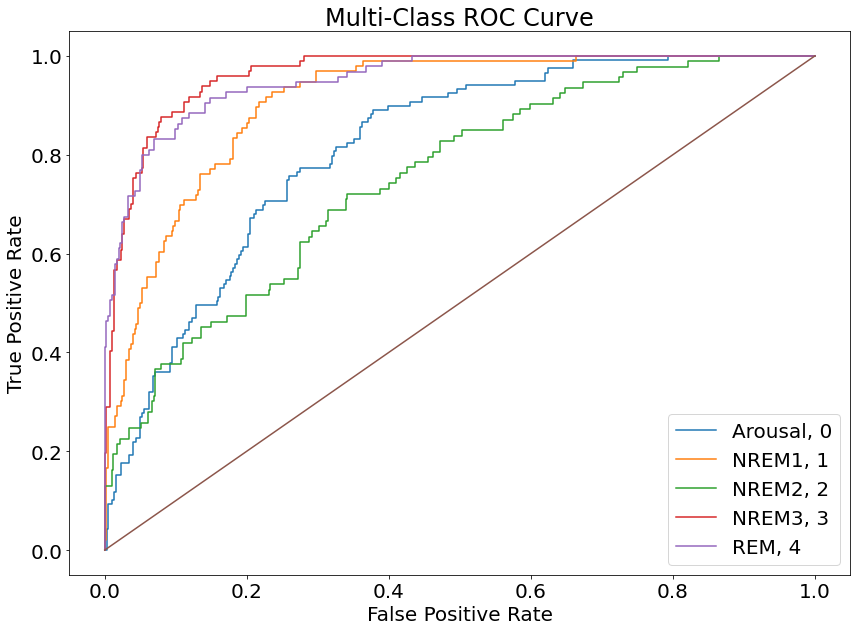

In [514]:
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [515]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [516]:
print(roc_auc_agg, mcc)

0.891865 0.3948924097299864
